# Test de transformation de fourier

## Importation des librairies

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math as m
from scipy import stats
import pywt

## Extraction des données

In [6]:
df=pd.read_csv("../Data/DataPully/DataPully.txt", sep=";") #Test sur les données horaires de la station de Pully
del df['stn']
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H')
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2024, 1980])]
df.head()
n = 24*180
dt = n/(365*24)

colonne_valeur = df.columns[1]

groupes = [df.iloc[i:i+n] for i in range(0, len(df), n)]
resultats = []
for groupe in groupes:
    if len(groupe) == n:  
        annee = groupe['time'].iloc[0].year
        moyenne = pd.to_numeric(groupe[colonne_valeur], errors='coerce').sum()
        resultats.append({'year': annee, f'{colonne_valeur}': moyenne})
time_serie = np.array(pd.DataFrame(resultats)['rre150h0'])

time_serie = (time_serie) / np.std(time_serie)

N = len(time_serie)

years = N*dt

time = np.arange(0, years+1) #+1 pour ne pas arrondir vers le bas

coi = np.minimum(time, time[::-1]) * np.sqrt(2)

## Wavelet

In [21]:
dj = 0.005
s0 = 2*dt
sf = years
J = dj**-1 * np.log2(sf/s0)
js = np.arange(0,J,1)
#scale = s0*2**(js*dj)
scale = np.logspace(0,2.1, num=3000)
print('scale (len, min, max): ',len(scale), scale.min(), scale.max())

wavelet = 'cmor1-1.5'
coefficients, frequencies = pywt.cwt(time_serie, scale, wavelet)
coefficients = np.abs(coefficients)
periods = (1 / frequencies)*dt

coefficients_av = np.zeros_like(coefficients)
av_window = 30
for i in range(coefficients.shape[0]):
    coefficients_av[i] = np.convolve(coefficients[i], np.ones(av_window)/av_window, mode='same')

print('periodes (min,max): ', periods.min(), periods.max())

scale (len, min, max):  3000 1.0 125.89254117941675
periodes (min,max):  0.3287671232876712 41.389328606931535


# Rain and period

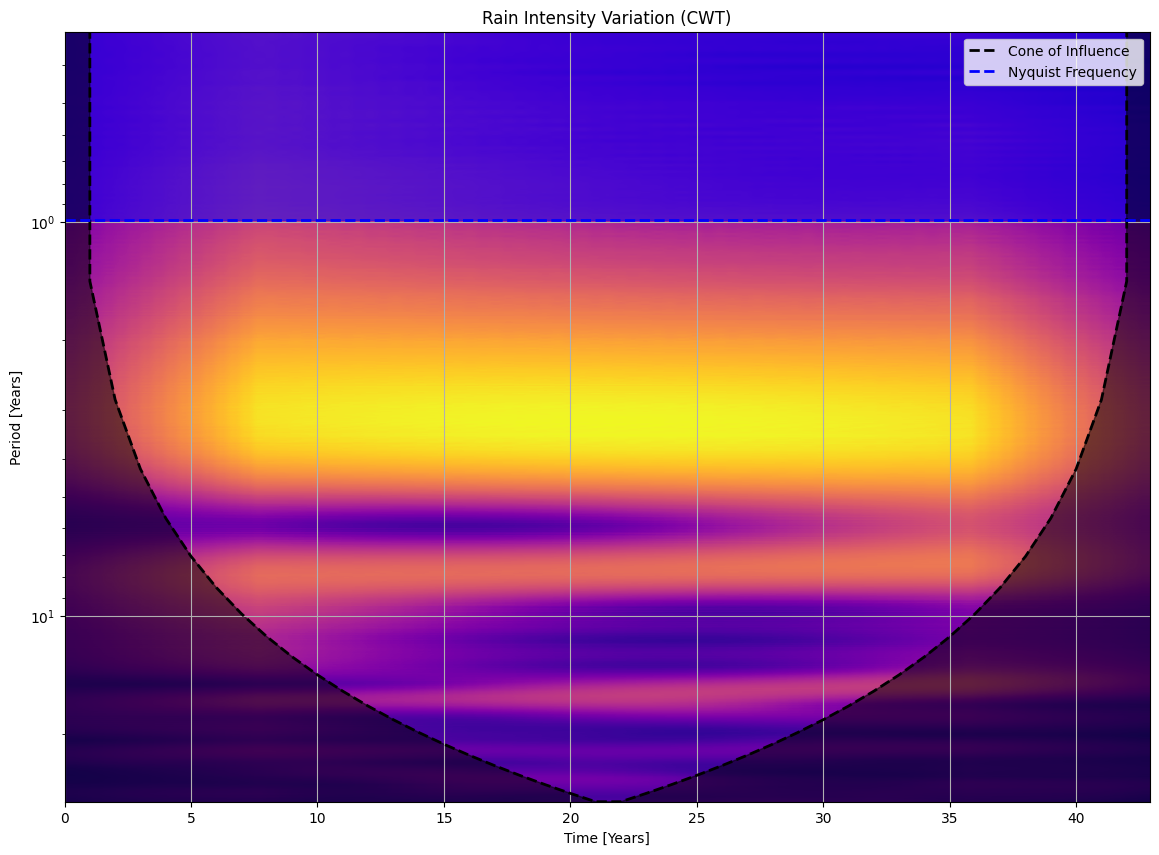

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(14, 10), sharex=True)
axs.imshow(np.abs(coefficients_av), extent=[0, years, periods[0], periods[-1]], aspect='auto', cmap='plasma')
axs.set_title("Rain Intensity Variation (CWT)")
axs.set_ylabel("Period [Years]")
axs.set_xlabel("Time [Years]")
axs.set_yscale('log')
axs.set_ylim(np.min(periods), np.min([np.max(periods),np.max(coi)]))
axs.set_xlim(0, years)
axs.invert_yaxis()
plt.grid('on')
plt.plot(time, coi, 'k--', linewidth=2, label='Cone of Influence')
plt.plot(time, np.ones(len(time))*2*dt, 'b--', linewidth=2, label='Nyquist Frequency')
plt.fill_between(time, np.ones(len(time))*2*dt, 0, color='blue', alpha=0.5)
plt.fill_between(time, coi, periods[-1], color='black', alpha=0.5)
plt.legend(loc='upper right')